# How to simulate ground truth for multi-phenotype z-scores?

Saikat Banerjee  
2023-07-01

We develop a generative model to create a feature matrix with realistic
ground truth to benchmark different methods.

# About

Here, I try to develop a generative model to create a feature matrix
with *realistic* ground truth in order to benchmark different methods.

Matrix factorization methods represent an observed $N \times P$ data
matrix $\mathbf{Y}$ as:

$$
\mathbf{Y} = \mathbf{L}\mathbf{F}^{\intercal} + \mathbf{E}
$$

where $\mathbf{L}$ is an $N \times K$ matrix, $\mathbf{F}$ is a
$P \times K$ matrix, and $\mathbf{E}$ is an $N \times P$ matrix of
residuals. For consistency, we adopt the notation and terminology of
factor analysis, and refer to $\mathbf{L}$ as the **loadings** and
$\mathbf{F}$ as the **factors**.

Different matrix factorization methods assume different constraints on
$\mathbf{L}$ and $\mathbf{F}$. For example, PCA assumes that the columns
of $\mathbf{L}$ are orthogonal and the columns of $\mathbf{F}$ are
orthonormal. For the purpose of generating a ground truth, we will use a
generative model,

$$
\mathbf{Y} = \mathbf{M} + \mathbf{L}\mathbf{F}^{\intercal} + \mathbf{E}\,,
$$ where every row of $\mathbf{M}$ is equal to the mean value for each
feature. The noise $\mathbf{E}$ is sampled from
$\mathcal{N}(0, \sigma^2 \mathbf{I})$. Equivalently, for sample
(phenotype) $i$ and feature (SNP) $j$, $$
y_{ij} = m_j + \sum_{k = 1}^K l_{ik}f_{jk} + e_j
$$

We will make some realistic assumptions of $\mathbf{M}$, $\mathbf{L}$,
$\mathbf{F}$ and $\mathbf{E}$, as discussed below.

# Getting setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps as mpl_cmaps
import matplotlib.colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram

# Input Dimensions

In [2]:
ntrait = 4 # categories / class
ngwas  = 100 # N
nsnp   = 1000 # P
nfctr  = 20 # K

# Generate latent factors

The matrix $\mathbf{F}$ of latent factors, size $P \times K$.
Properties: - Semi-orthogonal matrix - Columns are $K$ orthonormal
vectors (all orthogonal to each other: **ortho**; all of unit length:
\*\*normal”)

In [3]:
from scipy import stats as spstats
F = spstats.ortho_group.rvs(nsnp)[:, :nfctr]

# Quickly check if vectors are orthonormal
np.testing.assert_array_almost_equal(F.T @ F, np.identity(nfctr))

In [4]:
def do_standardize(Z, axis = 0, center = True, scale = True):
    '''
    Standardize (divide by standard deviation)
    and/or center (subtract mean) of a given numpy array Z
    
    axis: the direction along which the std / mean is aggregated.
        In other words, this axis is collapsed. For example,
        axis = 0, means the rows will aggregated (collapsed).
        In the output, the mean will be zero and std will be 1
        along the remaining axes.
        For a 2D array (matrix), use axis = 0 for column standardization
        (with mean = 0 and std = 1 along the columns, axis = 1).
        Simularly, use axis = 1 for row standardization
        (with mean = 0 and std = 1 along the rows, axis = 0).
        
    center: whether or not to subtract mean.
    
    scale: whether or not to divide by std.
    '''
    dim = Z.ndim
    
    if scale:
        Znew = Z / np.std(Z, axis = axis, keepdims = True)
    else:
        Znew = Z.copy()
        
    if center:
        Znew = Znew - np.mean(Znew, axis = axis, keepdims = True)

    return Znew

def get_equicorr_feature(n, p, rho = 0.8, seed = None, standardize = True):
    '''
    Return a matrix X of size n x p with correlated features.
    The matrix S = X^T X has unit diagonal entries and constant off-diagonal entries rho.
    
    '''
    if seed is not None: np.random.seed(seed)
    iidx = np.random.normal(size = (n , p))
    comR = np.random.normal(size = (n , 1))
    x    = comR * np.sqrt(rho) + iidx * np.sqrt(1 - rho)

    # standardize if required
    if standardize:
        x = do_standardize(x)

    return x

def get_blockdiag_features(n, p, rholist, groups, rho_bg = 0.0, seed = None, standardize = True):
    '''
    Return a matrix X of size n x p with correlated features.
    The matrix S = X^T X has unit diagonal entries and 
    k blocks of matrices, whose off-diagonal entries 
    are specified by elements of `rholist`.
    
    rholist: list of floats, specifying the correlation within each block
    groups: list of integer arrays, each array contains the indices of the blocks.
    '''
    np.testing.assert_equal(len(rholist), len(groups))
    
    if seed is not None: np.random.seed(seed)
    iidx = get_equicorr_feature(n, p, rho = rho_bg)

    # number of blocks
    k = len(rholist)
    
    # zero initialize
    x = iidx.copy() #np.zeros_like(iidx)
    
    for rho, grp in zip(rholist, groups):
        comR = np.random.normal(size = (n, 1))
        x[:, grp] = np.sqrt(rho) * comR + np.sqrt(1 - rho) * iidx[:, grp]

    # standardize if required
    if standardize:
        x = do_standardize(x)

    return x


def get_blockdiag_matrix(n, rholist, groups):
    R = np.ones((n, n))

    for i, (idx, rho) in enumerate(zip(groups, rholist)):
        nblock = idx.shape[0]
        xblock = np.ones((nblock, nblock)) * rho
        R[np.ix_(idx, idx)] = xblock
        
    return R

# def get_correlated_features (n, p, R, seed = None, standardize = True, method = 'cholesky'):
#     '''
#     method: Choice of method, cholesky or eigenvector or blockdiag.
#     '''

#     # Generate samples from independent normally distributed random
#     # variables (with mean 0 and std. dev. 1).
#     x = norm.rvs(size=(p, n))

#     # We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
#     # the Cholesky decomposition, or the we can construct `c` from the
#     # eigenvectors and eigenvalues.

#     if method == 'cholesky':
#         # Compute the Cholesky decomposition.
#         c = cholesky(r, lower=True)
#     else:
#         # Compute the eigenvalues and eigenvectors.
#         evals, evecs = eigh(r)
#         # Construct c, so c*c^T = r.
#         c = np.dot(evecs, np.diag(np.sqrt(evals)))
#     # Convert the data to correlated random variables. 
#     y = np.dot(c, x)
#     return y

def get_sample_indices(ntrait, ngwas, shuffle = True):
    '''
    Distribute the samples in the categories (classes)
    '''
    rs = 0.6 * np.random.rand(ntrait) + 0.2 # random sample from [0.2, 0.8)
    z = np.array(np.round((rs / np.sum(rs)) * ngwas), dtype = int)
    z[-1] = ngwas - np.sum(z[:-1])
    tidx = np.arange(ngwas)
    if shuffle:
        np.random.shuffle(tidx)
    bins = np.zeros(ntrait + 1, dtype = int)
    bins[1:] = np.cumsum(z)
    sdict = {i : np.sort(tidx[bins[i]:bins[i+1]]) for i in range(ntrait)}
    return sdict

def plot_covariance_heatmap(ax, X):
    return plot_heatmap(ax, np.cov(X))

def plot_heatmap(ax, X):
    '''
    Helps to plot a heatmap
    '''
    cmap1 = mpl_cmaps.get_cmap("YlOrRd").copy()
    cmap1.set_bad("w")
    norm1 = mpl_colors.TwoSlopeNorm(vmin=0., vcenter=0.5, vmax=1.)
    im1 = ax.imshow(X.T, cmap = cmap1, norm = norm1, interpolation='nearest', origin = 'upper')

    ax.tick_params(bottom = False, top = True, left = True, right = False,
                    labelbottom = False, labeltop = True, labelleft = True, labelright = False)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im1, cax=cax, fraction = 0.1)
    return

def reduce_dimension_svd(X, nfeature = None):
    if k is None: k = int(X.shape[1] / 10)
    k = max(1, k)
    U, S, Vt = np.linalg.svd(X)
    Uk = U[:, :k]
    Sk = S[:k]
    return Uk @ Sk

# L_qr_ortho, L_qr_eig = orthogonalize_qr(do_standardize(L_full))
# #idsort = np.argsort(L_eig)[::-1]
# #idselect = idsort[:nfctr]
# idselect = np.arange(nfctr)
# L_qr =  L_qr_ortho[:, idselect] @ np.diag(L_qr_eig[idselect])

# L_svd_ortho, L_svd_eig = orthogonalize_svd(do_standardize(L_full), k = nfctr)
# L_svd = L_svd_ortho @ np.diag(L_svd_eig)

# Generate loadings of each factor

The matrix $\mathbf{L}$ of loadings, size $N \times K$. It encapsulates
the similarity and distinctness of the samples in the latent space. We
design $\mathbf{L}$ to contain the a covariance structure similar to the
realistic data. The covariance of $\mathbf{L}$ is shown in
[Figure 1](#fig-loadings-covariance-example)

**To-Do:** Is there a way to enforce the columns of $\mathbf{L}$ to be
orthogonal? This can be both good and bad. Good, because many matrix
factorization methods like PCA, etc assume that W is orthogonal. Bad,
because real data may not be orthogonal.

In [5]:
sample_dict = get_sample_indices(ntrait, ngwas, shuffle = False)
sample_indices = [x for k, x in sample_dict.items()]
rholist = [0.7 for x in sample_indices]
rholist = [0.9, 0.5, 0.6, 0.9]

In [6]:
L_full = get_blockdiag_features(1000, ngwas, rholist, sample_indices, rho_bg = 0.0, seed = 2000).T
L = L_full[:, :nfctr]

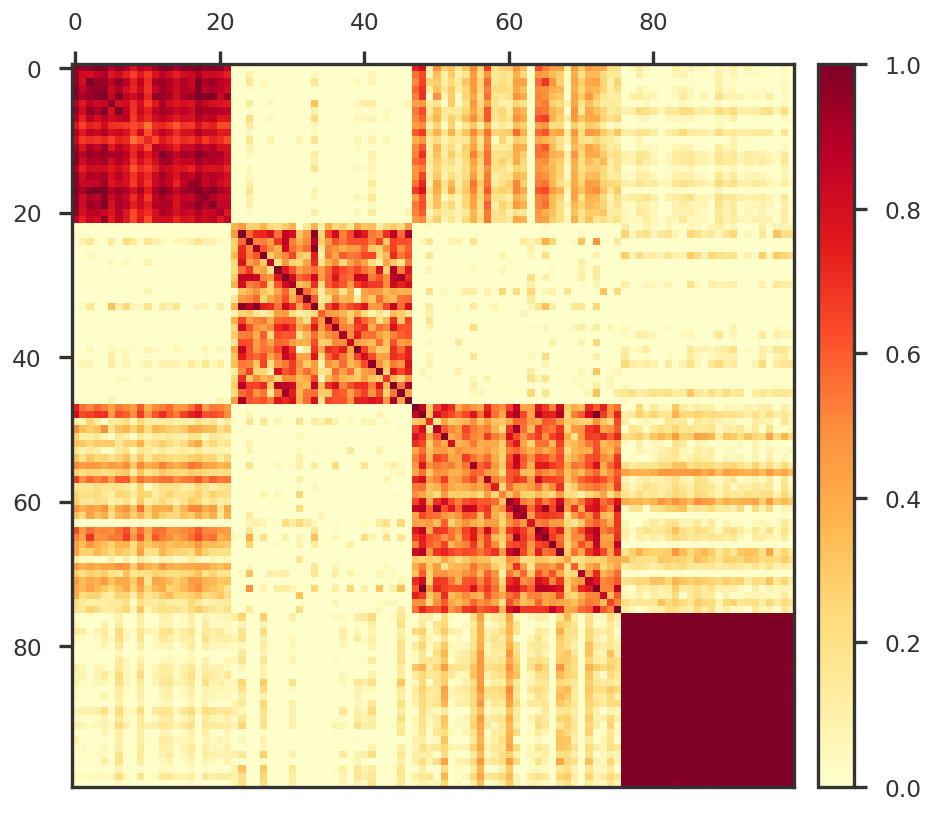

In [7]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

plot_covariance_heatmap(ax1, L)

plt.tight_layout()
plt.show()

The covariance of
$\mathbf{Y}_{\mathrm{true}} = \mathbf{L}\mathbf{F}^{\intercal}$ is shown
in the left panel of **?@fig-Ytrue-visual**. In the right panel, we show
the covariance of $\mathbf{Y}_{\mathrm{true}}\mathbf{F}$.

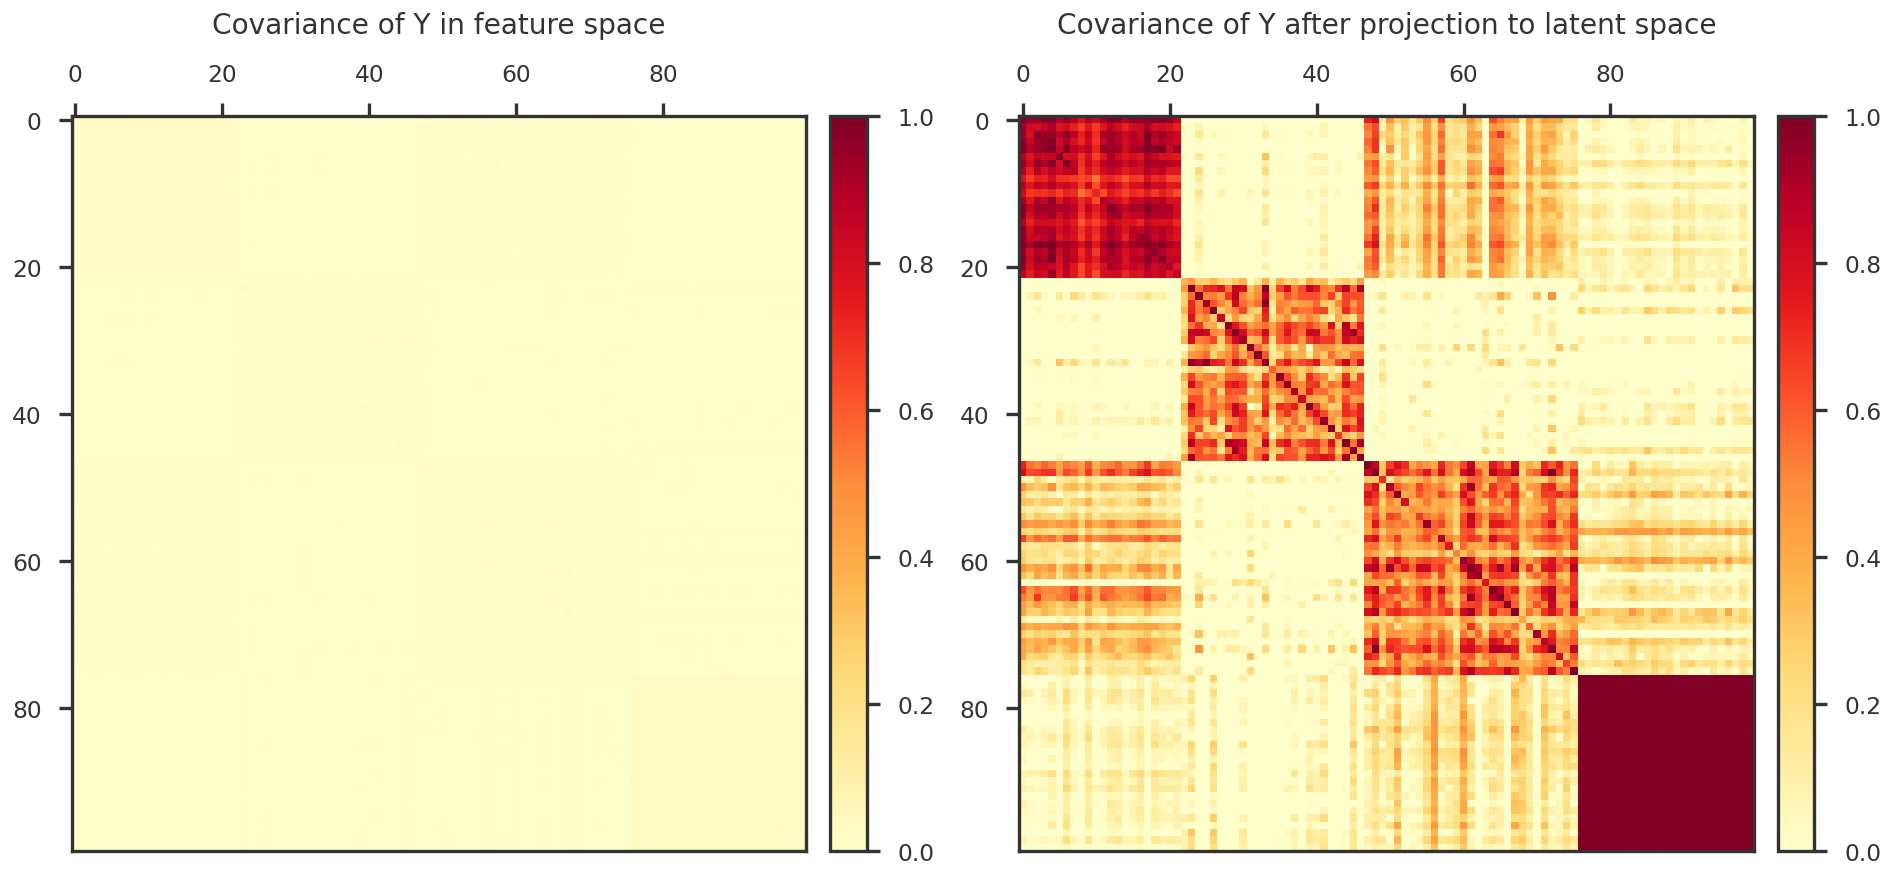

In [8]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

Y_true = L @ F.T
Y_true_proj = Y_true @ F

plot_covariance_heatmap(ax1, Y_true)
plot_covariance_heatmap(ax2, Y_true_proj)

ax1.set_title("Covariance of Y in feature space", pad = 50)
ax2.set_title("Covariance of Y after projection to latent space", pad = 50)

plt.tight_layout()
plt.show()

### Approximate methods to obtain loadings decomposition

Enforcing orthogonality on the loading will naturally overshrink the
similarity and enhance the distinctness. Still, we can reduce the
dimension of `L_full` using truncated SVD and use the projection of
`L_full` on the first $K$ components of the right singular vector.

Another option is to use a QR decomposition to obtain orthogonal
columns, scaled by some approximate eigenvalues: 1. Transpose `L_full`
and use QR decomposition. 2. $\mathbf{s}_{qr} \leftarrow$ eigenvalues
(diagonal of $\mathbf{R}$). 3. Define $\mathbf{s}'$ such that $s'_i = 1$
if $s_{qr} > 0$ and $s'_i = -1$ if $s_{qr} < 0$. 4. Choose K orthogonal
vectors from $\mathbf{Q}$ multiplied by $\mathrm{diag}(\mathbf{s}')$.
This does not work numerically, as shown below in
[Figure 3](#fig-loadings-decomposition)

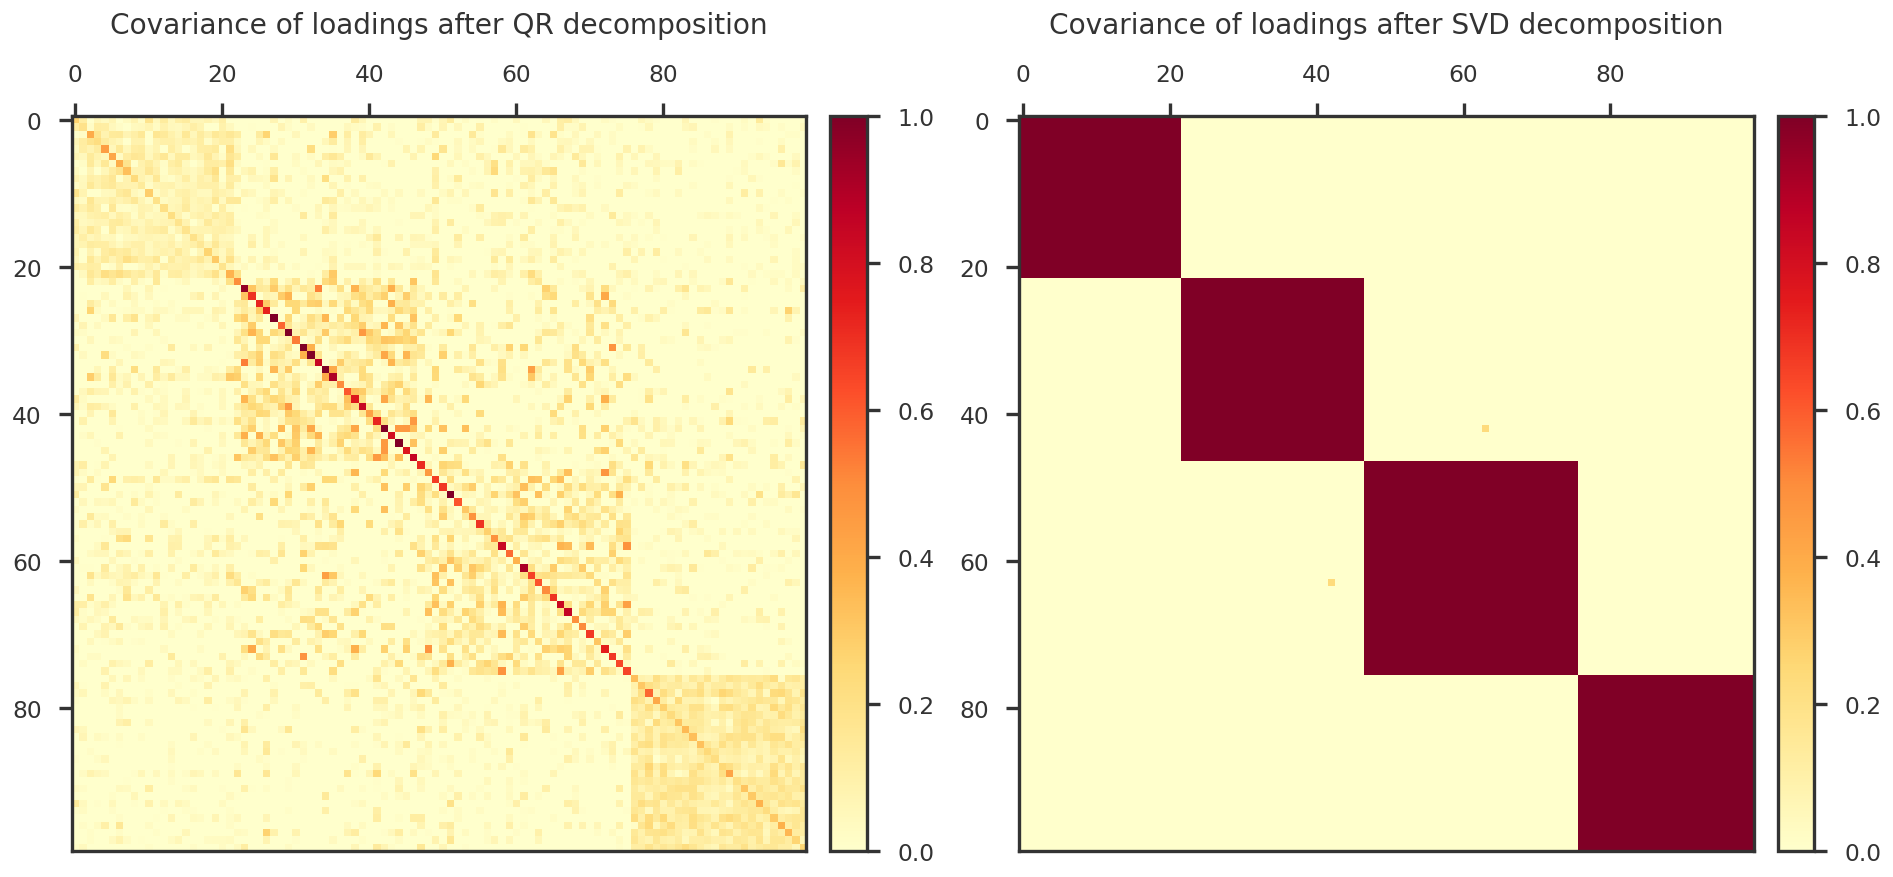

In [10]:
def orthogonalize_qr(X):
    Q, R = np.linalg.qr(X)
    eigv = np.diag(R).copy()
    eigv[eigv > 0] = 1.
    eigv[eigv < 0] = -1.
    U = Q @ np.diag(eigv)
    #return U, np.diag(R)
    return Q, np.abs(np.diag(R))

def orthogonalize_svd(X, k = None):
    if k is None:  k = X.shape[1]
    U, S, Vt = np.linalg.svd(X)
    Uk = U[:, :k]
    Sk = S[:k]
    return Uk, Sk

L_qr_ortho, L_qr_eig = orthogonalize_qr(do_standardize(L_full))
#idsort = np.argsort(L_eig)[::-1]
#idselect = idsort[:nfctr]
idselect = np.arange(nfctr)
L_qr =  L_qr_ortho[:, idselect] @ np.diag(L_qr_eig[idselect])

L_svd_ortho, L_svd_eig = orthogonalize_svd(do_standardize(L_full), k = nfctr)
L_svd = L_svd_ortho @ np.diag(L_svd_eig)


fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_covariance_heatmap(ax1, L_qr)
plot_covariance_heatmap(ax2, L_svd)

ax1.set_title("Covariance of loadings after QR decomposition", pad = 50)
ax2.set_title("Covariance of loadings after SVD decomposition", pad = 50)


plt.tight_layout()
plt.show()

# Generate Data

| variable      | data                                                                      |
|------------------------------------|------------------------------------|
| `Y_true`      | Ground truth                                                              |
| `Y_true_proj` | Projection of ground truth on the latent factors                          |
| `Y`           | Observed data                                                             |
| `Y_std`       | Observed data, standardized to mean 0 and std 1 for each feature (column) |
| `Y_std_proj`  | Projection of `Y_std` on the latent factors                               |

In [11]:
# fixed noise for every SNP
sigma2 = np.random.uniform(1e-2, 5.0, nsnp)
noise = np.random.multivariate_normal(np.zeros(nsnp), np.diag(sigma2), size = ngwas)
meanshift = np.random.normal(0, 10, size = (1, nsnp))

# Generate data and its projections on true F
Y_true = L @ F.T
Y_true_proj = Y_true @ F
Y = Y_true + meanshift + noise
Y_std = do_standardize(Y)
Y_std_proj = Y_std @ F

We obtain the observed $\mathbf{Y}$ by adding noise and mean to
$\mathbf{Y}_{\mathrm{true}}$. The covariance of $\mathbf{Y}$ is shown in
the left panel of **?@fig-Yobs-visual**. In the right panel, we show the
covariance of $\mathbf{Y}\mathbf{F}$.

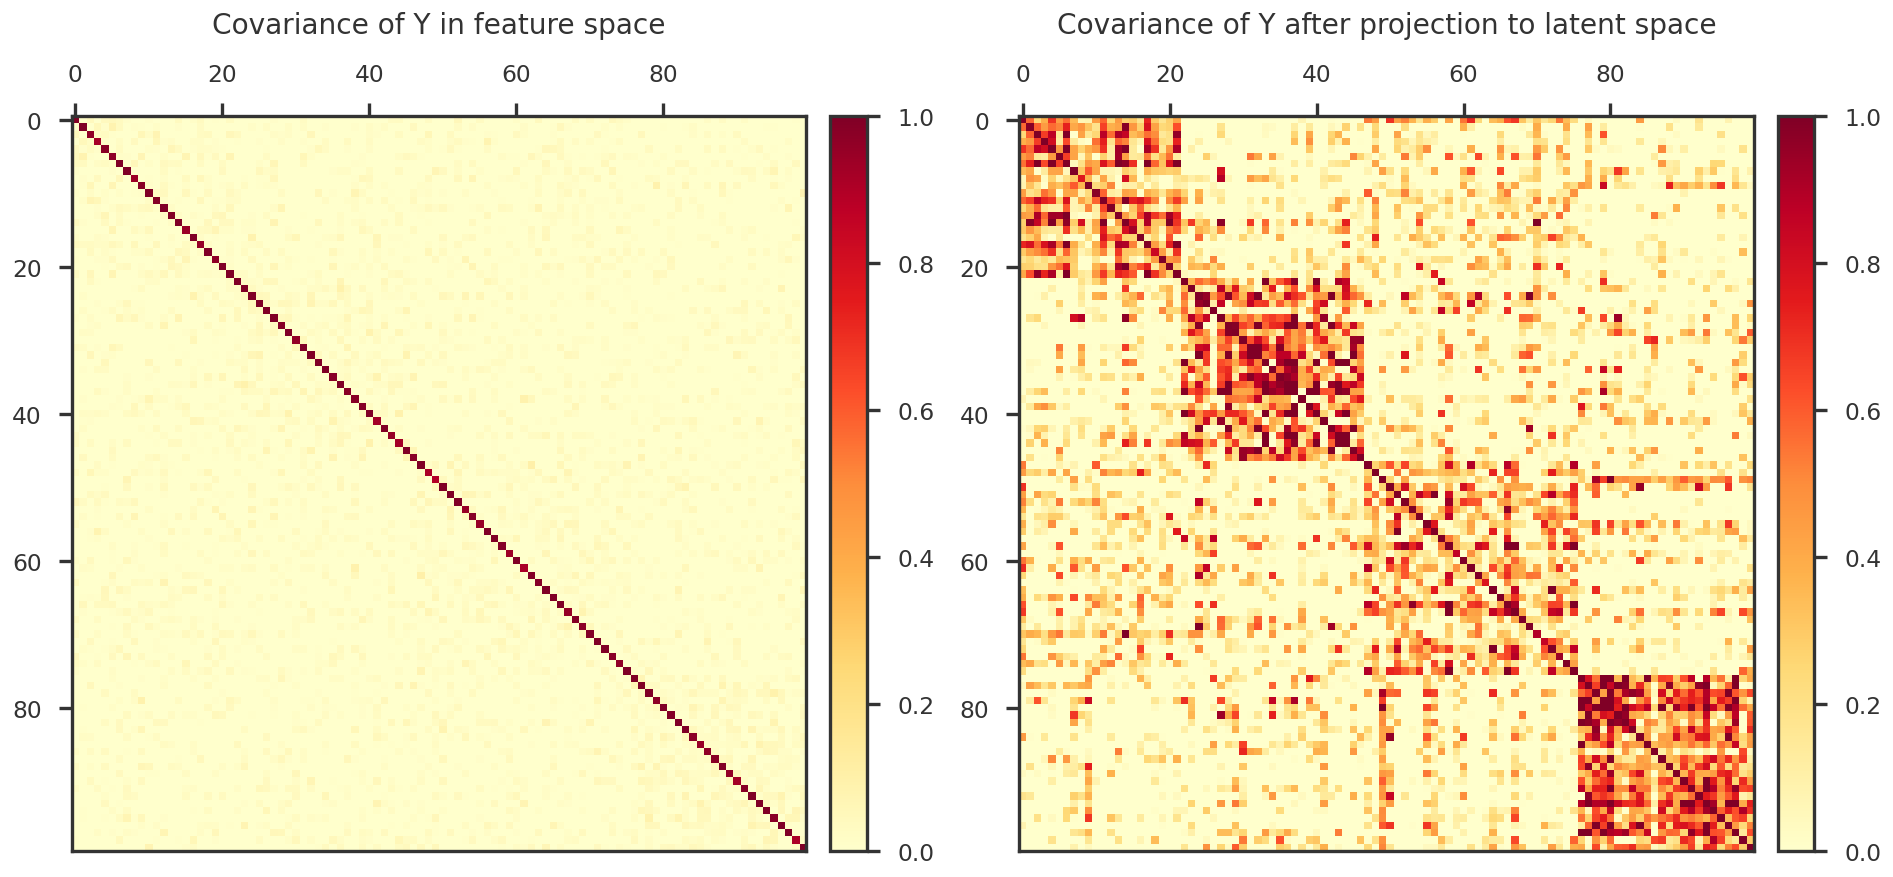

In [12]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_covariance_heatmap(ax1, Y_std)
plot_covariance_heatmap(ax2, Y_std_proj)

ax1.set_title("Covariance of Y in feature space", pad = 50)
ax2.set_title("Covariance of Y after projection to latent space", pad = 50)

plt.tight_layout()
plt.show()

# Plot distribution of each feature

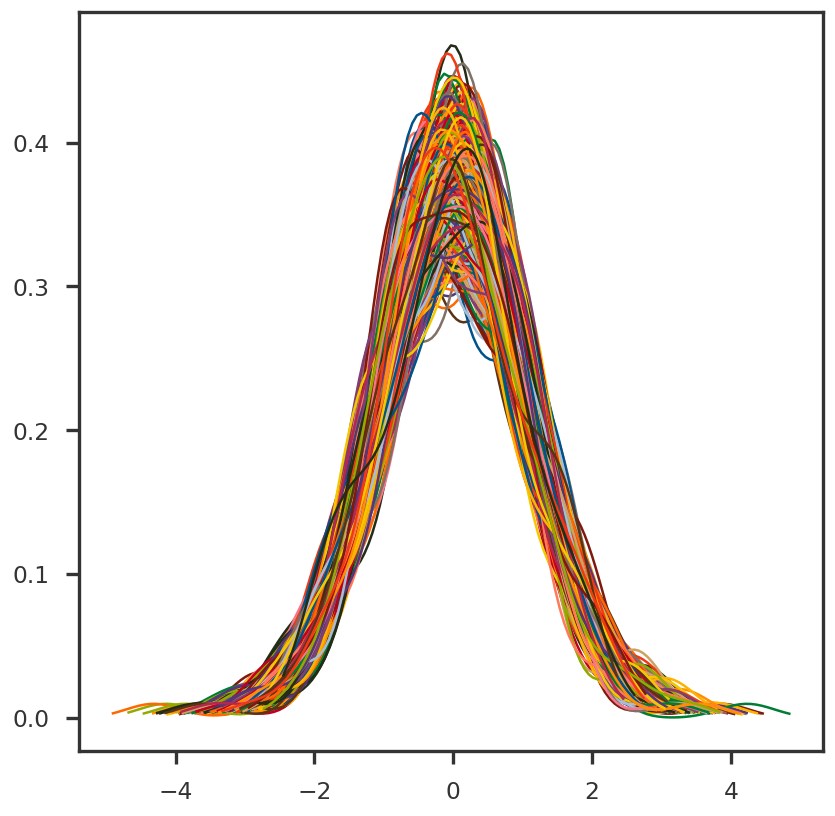

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(Y.shape[1]):
    x = Y_std[:, i]
    outlier_mask = mpy_histogram.iqr_outlier(x, axis = 0, bar = 5)
    data = x[~outlier_mask]
    xmin, xmax, bins, xbin = mpy_histogram.get_bins(data, 100, None, None)
    curve = mpy_histogram.get_density(xbin, data)
    ax1.plot(xbin, curve)
plt.show()

# Can SVD decomposition capture the signal?

In [Figure 6](#fig-svd-components), we look at the separation of the
underlying features using - projection of $\mathbf{Y}_{\mathrm{true}}$
on $\mathbf{F}$ (left panel). - projection of $\mathbf{Y}$ on
$\mathbf{F}$ (center panel). - principal components obtained from SVD of
$\mathbf{Y}$ (right panel).

In [14]:
U, S, Vt = np.linalg.svd(Y_std, full_matrices=False)
pcomps_svd = U[:, :nfctr] @ np.diag(S[:nfctr])

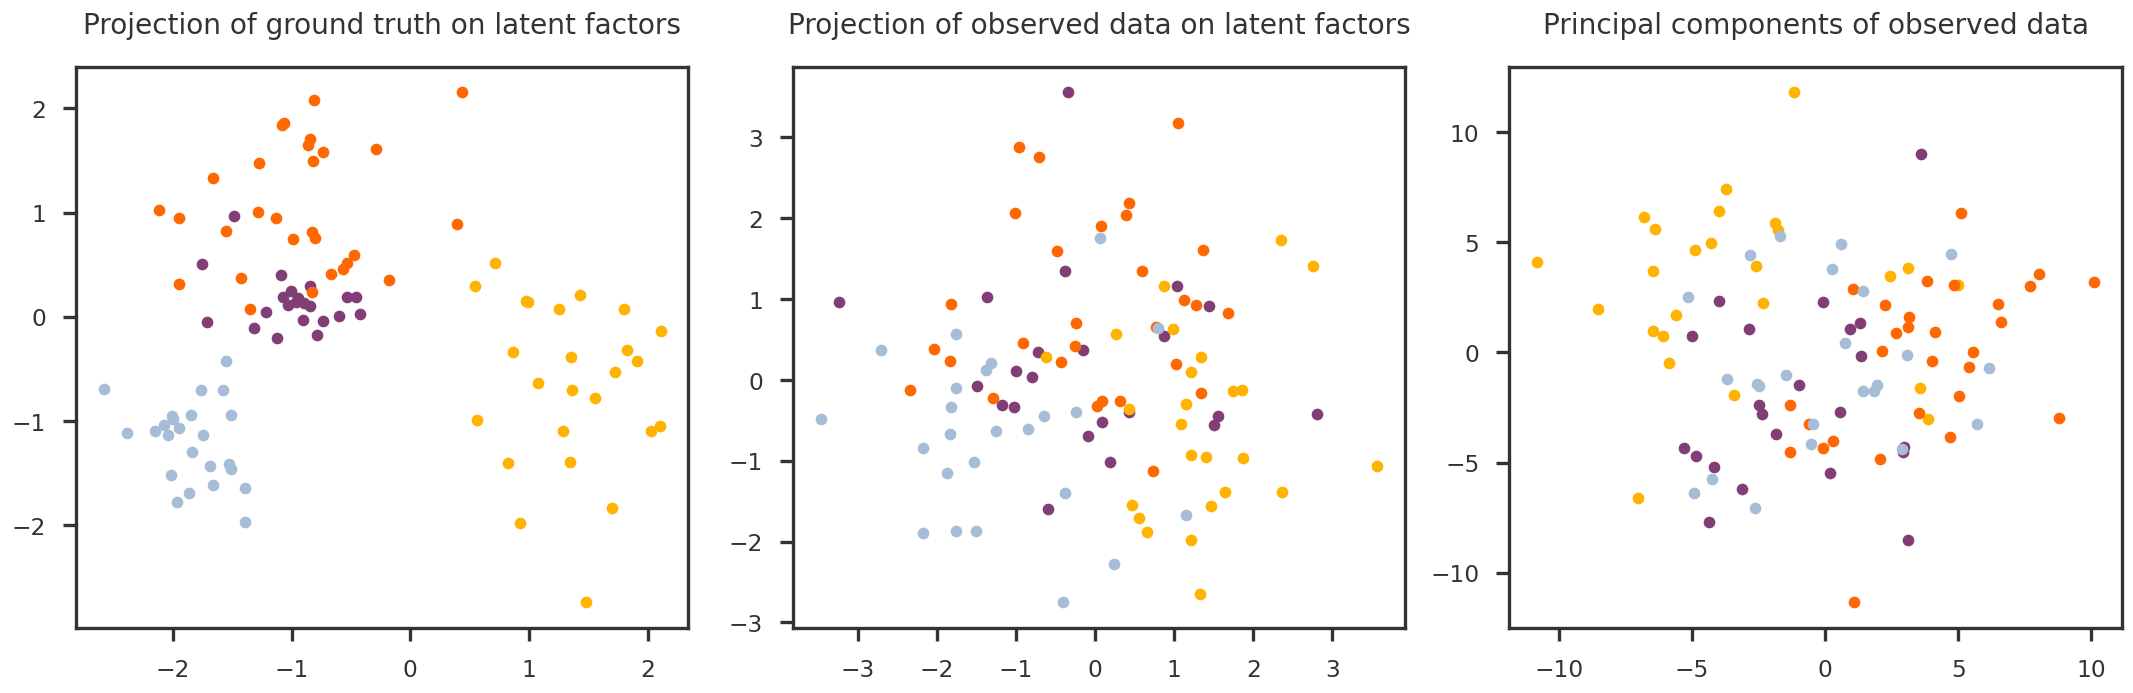

In [15]:
fig = plt.figure(figsize = (18, 6))

idx1 = 1
idx2 = 2

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

mcolors = mpl_stylesheet.kelly_colors()
for i, grp in enumerate(sample_indices):
    ax1.scatter(Y_true_proj[grp, idx1], Y_true_proj[grp, idx2], color = mcolors[i])
    ax2.scatter(Y_std_proj[grp, idx1], Y_std_proj[grp, idx2], color = mcolors[i])
    ax3.scatter(pcomps_svd[grp, idx1], pcomps_svd[grp, idx2], color = mcolors[i])
    
ax1.set_title ("Projection of ground truth on latent factors", pad = 20)
ax2.set_title ("Projection of observed data on latent factors", pad = 20)
ax3.set_title ("Principal components of observed data", pad = 20)

plt.tight_layout()
plt.show()

In [18]:
Ypred_svd = pcomps_svd @ Vt[:nfctr, :]
Y_true_std = do_standardize(Y_true)

np.sqrt(np.sum(np.square(Ypred_svd - Y_true) / np.square(Y_true)))

230973.68978816015